In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance
import pymorphy2

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Задание

Реализуйте максимально эффективным образом алгоритм иерархической кластеризации с алгоритмом объединения single-link clustering для точек, расположенных на прямой. Опишите алгоритм, а также найдите пример, когда подобный алгоритм показывает «плохие» результаты.

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений. Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер

* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = \frac{1}{2} \cdot d(C_i, C_k) + \frac{1}{2} \cdot d(C_j, C_k) - \frac{1}{2} \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin
import scipy.cluster.hierarchy as sch
from copy import deepcopy

class Clustering(BaseEstimator, ClusterMixin):
    
    def __init__(self,n_clusters=2, **kwargs):

        self.n_clusters = n_clusters
        self.a_i = 1/2
        self.a_j = 1/2
        self.c = -1/2

        return
        
    def fit_predict(self, x):
        #матрица расстояний
        dist_matrix = np.ones((len(x), len(x)))
        for i in range(len(x)):
            for j in range(len(x)):
                if i != j:
                    dist_matrix[i][j] = abs(x[i] - x[j])
                else:
                    dist_matrix[i][j] = np.inf
        #матрица связей
        self.Z = []
        self.n_steps = len(x)-1
        self.clusts = [[i] for i in range(len(x))]
        self.cl = deepcopy(self.clusts)
        
        for i in range(self.n_steps):
            if i == len(x) - self.n_clusters:
                #нужное разбиение
                self.clusters = deepcopy(self.clusts)
            
            ind = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
            
            C_i,C_j = self.clusts[ind[0]],self.clusts[ind[1]]
            C_ij = C_i + C_j
            self.clusts.remove(C_i)
            self.clusts.remove(C_j)
            self.clusts.append(C_ij)
            self.cl.append(C_ij)
            
            self.Z.append([self.cl.index(C_i), self.cl.index(C_j), dist_matrix[ind[0],ind[1]], len(C_i)+len(C_j)])
            
            new_dist0 = np.ones(dist_matrix.shape[0])
            new_dist1 = np.ones(dist_matrix.shape[0]+1)
            for k in range(dist_matrix.shape[0]):
                new_dist0[k] = new_dist1[k] = self.a_i*dist_matrix[ind[0],k]+self.a_j*dist_matrix[ind[1],k]+\
                                                        self.c*abs(dist_matrix[ind[0],k]-dist_matrix[ind[1],k])
                if k in ind:
                    new_dist0[k] = new_dist1[k] = np.inf
            
            new_dist1[dist_matrix.shape[0]] = np.inf
            new_dist0 = np.expand_dims(new_dist0, axis=1)
            dist_matrix = np.concatenate((dist_matrix, new_dist0), 1)
            new_dist1 = np.expand_dims(new_dist1, axis=0)
            dist_matrix = np.concatenate((dist_matrix, new_dist1), 0)
            dist_matrix = np.delete(dist_matrix,(ind[0],ind[1]), 0)
            dist_matrix = np.delete(dist_matrix,(ind[0],ind[1]), 1)
            
        self.Z = np.array(self.Z, dtype='float64')
        clusters_labels = np.ones(len(x), dtype=int)
        
        for cluster_number, number in enumerate(self.clusters):
            clusters_labels[number] = cluster_number
        return clusters_labels
    
    def plot_dendrogram(self):
        plt.figure(figsize=(20, 10))
        sch.dendrogram(self.Z)


# Пример работы на хороших данных

In [3]:
x = np.array([0, 1, 2, 3, 4, 5, 25, 26, 30])
y = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1])

Our AGGL score 1.0. Our AGGL time 0.01699066162109375


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


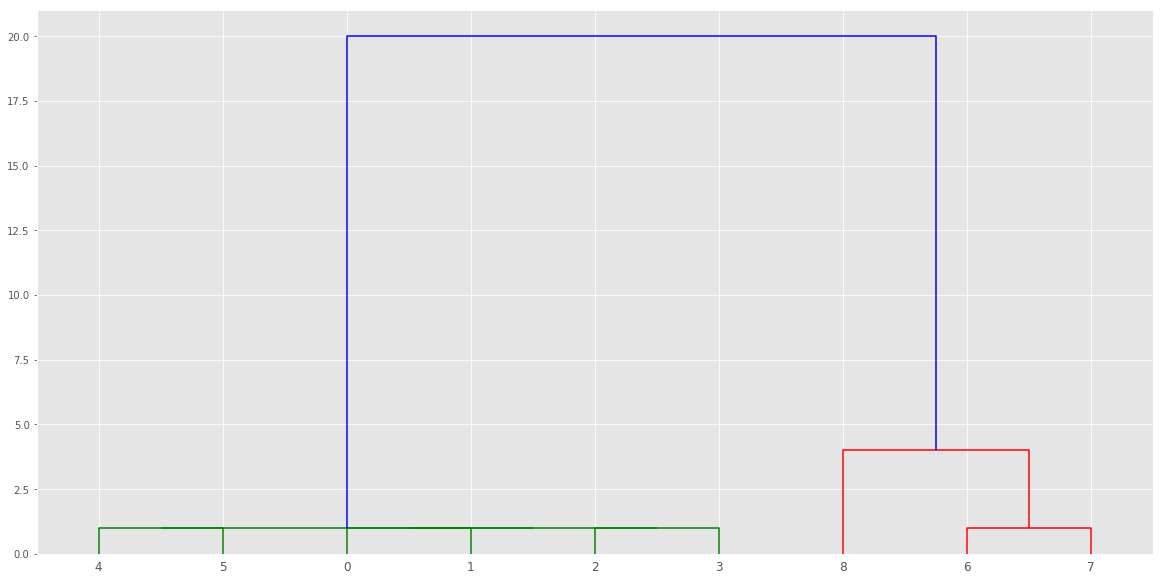

In [4]:
#кастомная реализация
сustum_aggl = Clustering()
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x.reshape(-1, 1))
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))
сustum_aggl.plot_dendrogram()

Результаты

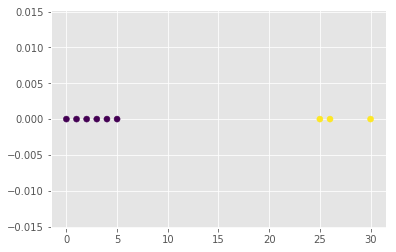

In [5]:
pl.scatter(x, [0]*len(x), c = aggl_pred)
pl.show()

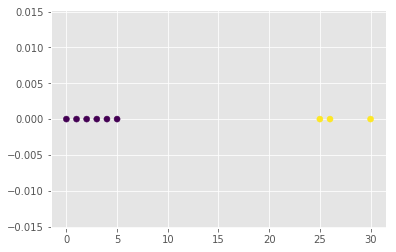

In [6]:
pl.scatter(x, [0]*len(x), c = y)
pl.show()

# Плохой пример

Недостаток этого метода состоит в том, что он имеет тенденцию создавать длинные кластеры, в которых соседние элементы одного кластера имеют небольшие расстояния, но элементы на противоположных концах кластера могут быть достаточно далеко. Это может привести к трудностям при определении классов, когда в один "большой" класс содеиняются два визуально отличимых кластера.

In [7]:
x = np.array([28, 0, 2, 5, 11, 9, 23, 30, 1])
y = np.array([2, 0, 0, 0, 1, 1, 2, 2, 0])

Примерная кратинка визуального разбиения

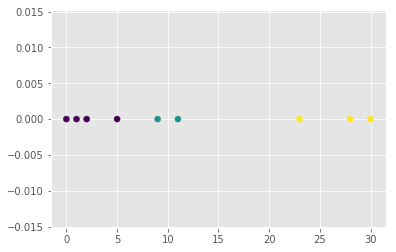

In [8]:
pl.scatter(x, [0]*len(x), c=y)
pl.show()

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


AGGL score 0.41558441558441556. AGGL time 0.003998994827270508


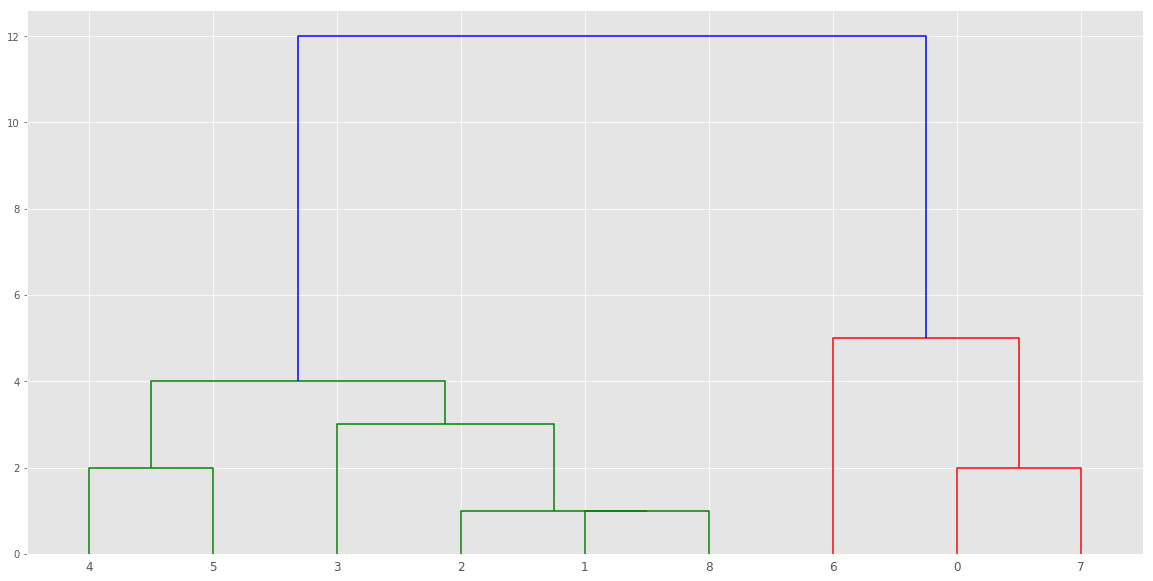

In [9]:
#кастомная реализация
сustum_aggl = Clustering(3)
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x.reshape(-1, 1))
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y, aggl_pred)
print ("AGGL score {}. AGGL time {}".format(aggl_score, aggl_diff))
сustum_aggl.plot_dendrogram()

Результаты кластеризации: видно, что первый кластер "слишком" длинный

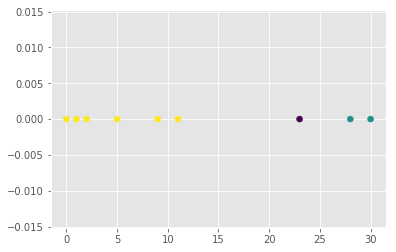

In [10]:
pl.scatter(x, [0]*len(x), c = aggl_pred)
pl.show()

Реальное разбиение

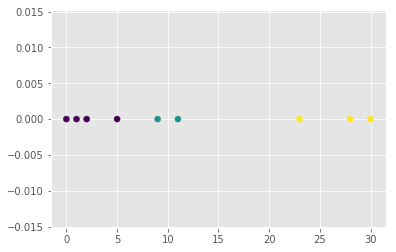

In [11]:
pl.scatter(x, [0]*len(x), c = y)
pl.show()